In [3]:
%load_ext autoreload
%autoreload 2
import iss_analysis as iss
import time
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
#import loompy
import scanpy as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#define gene sets
def filter_genes(gene_names):
    # get rid of gene models etc
    genes_Rik = np.array([ re.search('Rik$', s) is not None for s in gene_names ])
    genes_Gm = np.array([ re.search('Gm\d', s) is not None for s in gene_names ])
    genes_LOC = np.array([ re.search('LOC\d', s) is not None for s in gene_names ])
    genes_AA = np.array([ re.search('^[A-Z]{2}\d*$', s) is not None for s in gene_names ])

    skewed_genes = np.array([gene not in thresholded_geneset for gene in gene_names])
    
    keep_genes = np.logical_not(genes_Rik + genes_Gm + genes_LOC + genes_AA + skewed_genes) 
    
    return keep_genes

def load_data_zeisel_2018():
    """
    Load the scRNAseq data from Zeisel et al., 2018.

    Returns:
        exons_subset: n cells x n genes matrix pandas.Dataframe of read counts plus cell metadata
        gene_names: pandas.Series of gene names

    """
    exons_subset = pd.read_csv('/camp/lab/znamenskiyp/home/shared/resources/zeisel_2018/sensory_df.csv')
    gene_names = pd.Series(pd.read_csv('/camp/lab/znamenskiyp/home/shared/resources/zeisel_2018/gene_names.csv').to_numpy().flatten(), name='gene_symbol')

    return exons_subset, gene_names

def load_data_sharma_2020(filter=False):
    """
    Load the scRNAseq data from Sharma et al., 2020.

    Returns:
        exons_subset: n cells x n genes matrix pandas.Dataframe of read counts plus cell metadata
        gene_names: pandas.Series of gene names

    """
    resources_path = '/camp/lab/znamenskiyp/home/shared/resources/sharma_2020/'
    exons_subset = pd.DataFrame(np.load(resources_path + 'sharma_expression_matrix.npy'))
    sharma_cell_types = pd.read_csv(resources_path +"sharma_2020_GSM4130750_WT_1.csv", sep=',', header=None, nrows=1).to_numpy()[0][1:]
    exons_subset = pd.concat([pd.Series(sharma_cell_types, name='ClusterName'), exons_subset], axis=1)
    sharma_gene_names = pd.read_csv(resources_path + "sharma_2020_GSM4130750_WT_1.csv", sep=',', header=None, usecols=[0], skiprows=[0,1,2]).to_numpy().flatten()
    gene_names = pd.Series(sharma_gene_names, name='gene_symbol')
    
    if filter:
        keep_genes = filter_genes(gene_names)
        gene_names = gene_names.iloc[keep_genes]
        exons_subset = exons_subset[exons_subset.columns[np.insert(keep_genes, 0, True)]]
    
    return exons_subset, gene_names

In [ ]:
exons_df_curated, gene_names_curated = load_data_zeisel_2018()

In [68]:
exons_df_sharma, gene_names_sharma = load_data_sharma_2020()

In [70]:
#split into test and train groups
train_sharma, test_sharma, cluster_labels_sharma = iss.pick_genes.train_test_split(
    exons_df_sharma,
    'ClusterName',
    gene_filter = '\d',
    efficiency = 0.5
)

#compute mean expression for each cluster and gene
exons_matrix_sharma, cluster_ids_sharma, cluster_means_sharma, cluster_labels_sharma = iss.pick_genes.compute_means(
    exons_df_sharma,
    'ClusterName',
    gene_filter='\d'
)

#resample counts to account for efficiency of iss
resampled_exons_matrix_sharma, resampled_cluster_means_sharma = iss.pick_genes.resample_counts(
    exons_matrix_sharma,
    cluster_means_sharma,
    efficiency=0.5
)

#precompute cluster probabilities
cluster_probs_sharma = iss.pick_genes.compute_cluster_probabilities(
    resampled_exons_matrix_sharma.astype('float'),
    resampled_cluster_means_sharma,
    nu=0.001
)

In [71]:
def optimize_gene_set(cluster_probs, cluster_ids, gene_names, gene_set=(),
                      niter=100, subsample_cells=1):
    gene_set_history = []
    accuracy_history = []
    ordered_gene_list = []
    include_genes = np.isin(np.array(gene_names), gene_set)
    for i in range(niter):
        if subsample_cells < 1:
            cell_idx = np.random.rand(cluster_probs.shape[0]) < subsample_cells
            b, accuracy = iss.pick_genes.next_best_gene(include_genes, cluster_probs[cell_idx,:,:], cluster_ids[cell_idx])
        else:
            b, accuracy = iss.pick_genes.next_best_gene(include_genes, cluster_probs, cluster_ids)

        include_genes[b] = True
        print(f'added {gene_names.iloc[b]}, accuracy = {accuracy}')
        ordered_gene_list.append(gene_names.iloc[b])
        
        gene_set_history.append(include_genes)
        accuracy_history.append(accuracy)
    return include_genes, gene_set_history, accuracy_history, ordered_gene_list

In [74]:
# Select genes by running the optimization procedure
include_genes_sharma, gene_set_history_sharma, accuracy_history_sharma, ordered_gene_list_sharma = optimize_gene_set(
    cluster_probs_sharma, cluster_ids_sharma, gene_names_sharma, niter=60, subsample_cells=1)

added Cd24a, accuracy = 0.31636592153694226


added Rgs10, accuracy = 0.5026483526348864


added Ngfr, accuracy = 0.6326420684082952


added Tmem233, accuracy = 0.7050004488733279


added Calca, accuracy = 0.75177304964539


added Cntn1, accuracy = 0.7843612532543316


added Fxyd2, accuracy = 0.8147050902235389


added Ntrk2, accuracy = 0.829966783373732


added Nts, accuracy = 0.8437023072089056


added Jak1, accuracy = 0.8516922524463596


added Fxyd6, accuracy = 0.8617470149923692


added Ntrk3, accuracy = 0.8698267348954125


added Nbl1, accuracy = 0.875033665499596


added Tac1, accuracy = 0.8811383427596732


added Pvalb, accuracy = 0.8874225693509291


added Fxyd7, accuracy = 0.8916419786336296


added Synpr, accuracy = 0.8962204865786875


added Pcp4, accuracy = 0.9002603465302091


added Clec2l, accuracy = 0.9031331358290691


added Gal, accuracy = 0.9056468264655714


added Rgs5, accuracy = 0.9076218691085376


added Crip1, accuracy = 0.9121106023880061


added Tmem158, accuracy = 0.9137265463686147


added Gm7271, accuracy = 0.9151629410180447


added Chchd10, accuracy = 0.9174970823233684


added Sox11, accuracy = 0.9183050543136727


added Cd44, accuracy = 0.9189334769727983


added Hopx, accuracy = 0.9194721249663345


added Sprr1a, accuracy = 0.9199209982942813


added Prkca, accuracy = 0.9203698716222282


added Piezo2, accuracy = 0.9213573929437113


added Wbp5, accuracy = 0.9218960409372475


added Rarres1, accuracy = 0.9218960409372475


added Lgals1, accuracy = 0.9218960409372475


added Scn7a, accuracy = 0.9216267169404794


added Hn1, accuracy = 0.92153694227489


added Ppp1r1a, accuracy = 0.9206391956189963


added Pmp22, accuracy = 0.920818744950175


added Ctxn3, accuracy = 0.9204596462878176


added Cpne3, accuracy = 0.9201005476254601


added Lxn, accuracy = 0.9206391956189963


added Nefm, accuracy = 0.9197414489631026


added S100b, accuracy = 0.9190232516383876


added Cdkn1a, accuracy = 0.9187539276416196


added Gng2, accuracy = 0.9179459556513152


added Hspb1, accuracy = 0.9171379836610108


added S100a11, accuracy = 0.9168686596642428


added Tagln3, accuracy = 0.9158811383427596


added Ctnnbip1, accuracy = 0.9155220396804022


added Ly86, accuracy = 0.9148936170212766


added Ostf1, accuracy = 0.914265194362151


added Thy1, accuracy = 0.9130981237094892


added Srxn1, accuracy = 0.9120208277224168


added Cox5a, accuracy = 0.9107639824041656


added Iqsec2, accuracy = 0.9104048837418081


added Ubb, accuracy = 0.9089684890923782


added Phf24, accuracy = 0.9066343477870545


added Nefh, accuracy = 0.9051081784720352


added Fez1, accuracy = 0.9020558398419966


added Txn1, accuracy = 0.8985546278840111


added Calca, accuracy = 0.0


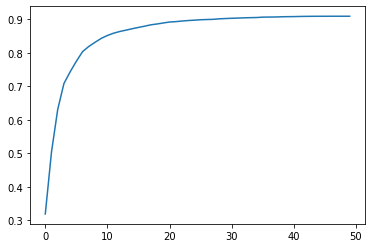

In [151]:
plt.plot(accuracy_history_sharma)

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def lognbinom(k, mu):
    """
    Log negative binomial PDF with r = 2.

    Fixing r to 2 is very computationally convenient because we don't need to
    compute any factorials.

    Args:
        k: counts
        mu: mean parameter

    Returns:
        Log negative binomial probability.

    """
    return np.log(k + 1) + np.log(mu / (mu + 2)) * k + np.log(2/(mu + 2)) * 2

def classify_cells(exons_matrix, cluster_means, gene_set, gene_names, nu=0.001):
    """
    Classify cells using a provided gene set.

    Args:
        exons_matrix: n cells x n genes matrix (numpy.ndarray) of read counts
        cluster_means: n clusters x n genes matrix (numpy.ndarray) of mean read
            counts for each cluster
        gene_set: list of genes to use for classification
        gene_names: list of genes corresponding to columns of exons_matrix
        nu: optional parameter added to the means of each cluster to "regularize"
            them. Otherwise any clusters with mean of 0 will have 0 probability
            of observing >0 reads.

    Returns:
        numpy.array of cluster assignments for each cell

    """
    include_genes = np.isin(np.array(gene_names), gene_set)
    cell_probs = np.empty((exons_matrix.shape[0], cluster_means.shape[0]))
    for i, cluster in enumerate(cluster_means):
        cell_probs[:,i] = lognbinom(exons_matrix[:, include_genes], cluster[include_genes] + nu).sum(axis=1)
    cluster_assignments = cell_probs.argmax(axis=1)
    return cluster_assignments

def plot_confusion_matrix(cluster_ids, cluster_assignments, cluster_labels,
                          display_counts=True):
    """
    Plot a confusion matrix for the provided cluster assignments.

    Args:
        cluster_ids: numpy.array of "true" cluster ids
        cluster_assignments: numpy.array of cluster assignments
        cluster_labels: list of cluster names
        display_counts: (Default: True) whether to show counts or normalized
            proportions

    Returns:
        Confusion matrix

    """
    c = confusion_matrix(
        cluster_ids,
        cluster_assignments,
    )

    if display_counts:
        normalize = None
        include_values = True
    else:
        normalize = 'true'
        include_values = False
    plt.figure(figsize=(20,20))
    ax = plt.subplot(111)
    cfmatrix = ConfusionMatrixDisplay.from_predictions(
        cluster_ids,
        cluster_assignments,
        display_labels=cluster_labels,
        xticks_rotation='vertical',
        cmap = plt.cm.get_cmap("magma_r").copy(),
        ax=ax,
        normalize=normalize,
        include_values=include_values,
        colorbar = False
    )
    cfmatrix.im_.cmap.set_under('w')  # Change color to white
    cfmatrix.im_.set_clim(0.01, 1)  # Set the limit beyond which everything is white
    cfmatrix.ax_.xaxis.label.set_size(20)
    cfmatrix.ax_.yaxis.label.set_size(20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    cbar = cfmatrix.figure_.colorbar(cfmatrix.im_, ticks = [0.001,0.2,0.4,0.6,0.8,1], format = "%.1f",
                              fraction=0.047, pad=0.015
                             )
    
    cbar.set_label(label = 'Classification accuracy', size=20)
    cbar.ax.tick_params(labelsize=20)
    plt.draw()
    figpath = '/nemo/lab/znamenskiyp/home/users/becalia/figs/'
    plt.savefig(f'{figpath}norm_med_sharma_resampled_cluster_confusion_matrix.svg', format='svg')
    plt.show()
    return c

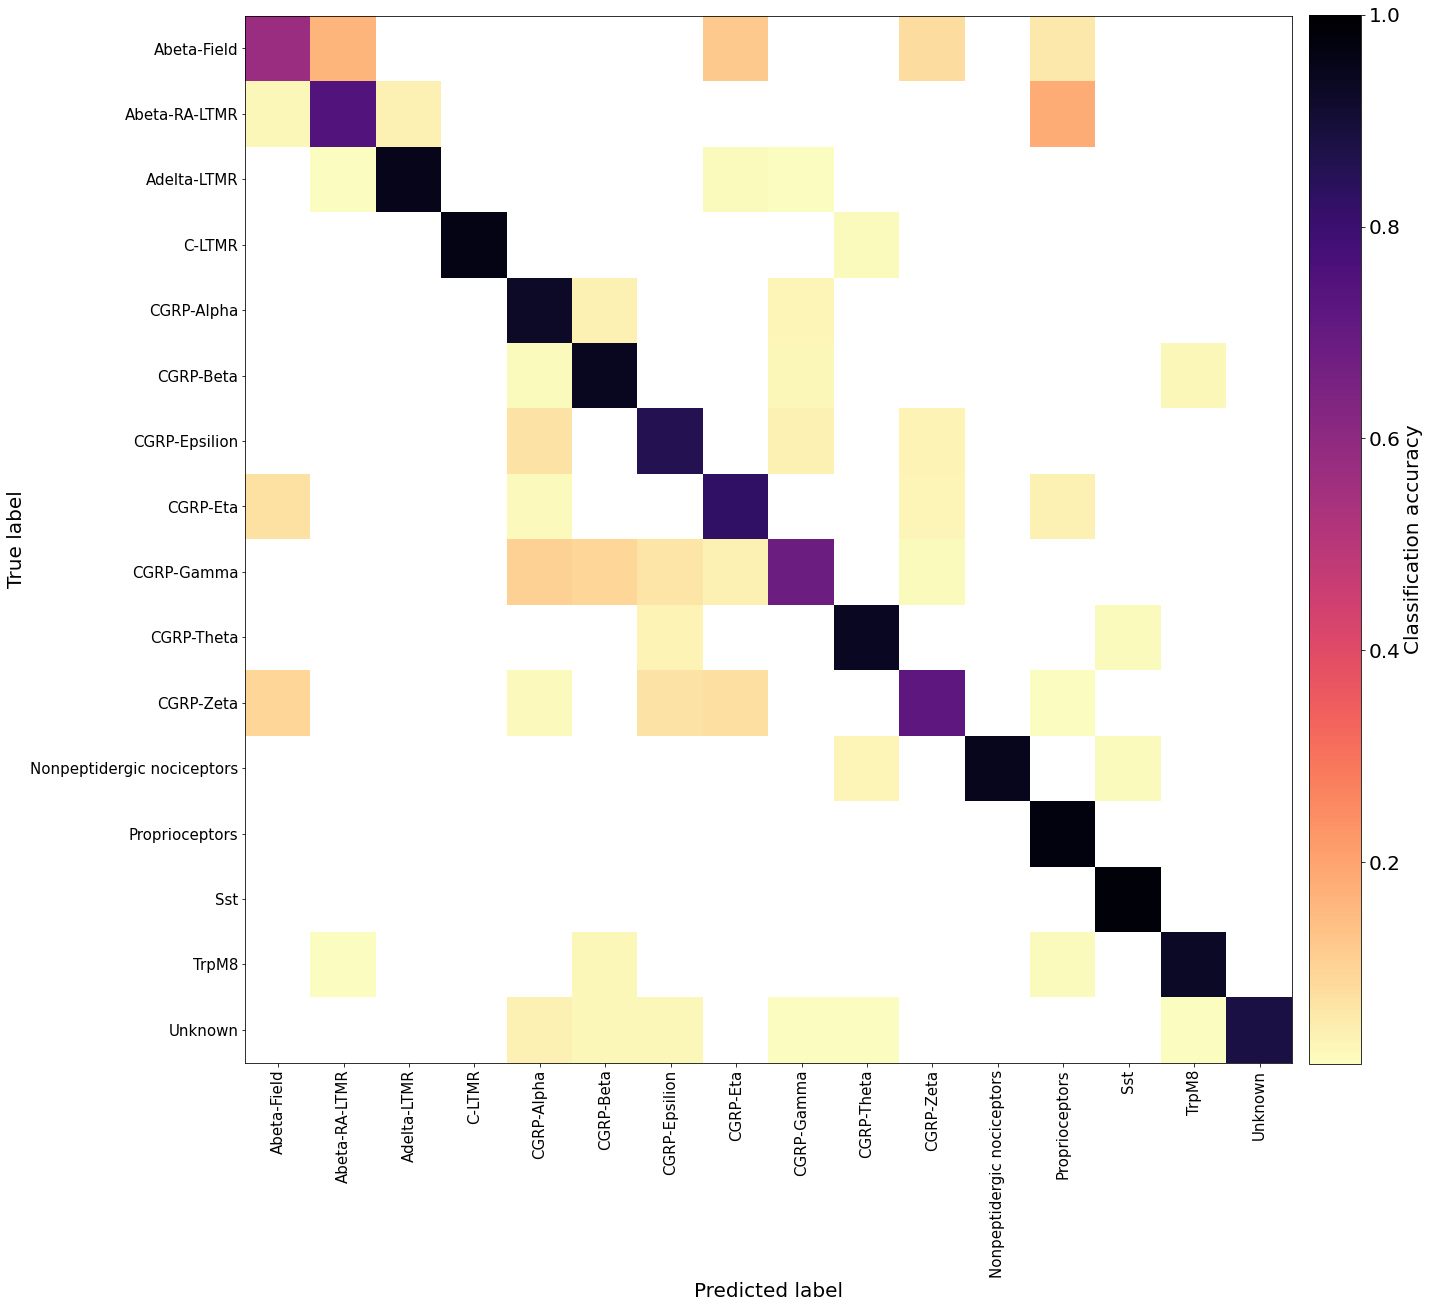

array([[ 146,   42,    2,    0,    2,    0,    0,   31,    0,    0,   20,
           0,   14,    0,    0,    0],
       [   6,  203,   10,    0,    1,    0,    0,    2,    0,    0,    1,
           0,   50,    0,    0,    0],
       [   0,    2,  173,    0,    0,    1,    0,    3,    2,    0,    1,
           0,    0,    0,    0,    0],
       [   2,    0,    0, 1489,    0,    6,    0,    2,    6,   27,    7,
           4,    0,    5,    4,    2],
       [   0,    0,    0,    0, 1331,   53,   13,    0,   37,    0,    1,
           0,    1,    0,    2,    2],
       [   0,    0,    0,    0,    2,  127,    0,    0,    3,    0,    0,
           0,    0,    0,    3,    0],
       [   0,    0,    0,    0,   56,    8,  727,    0,   31,    2,   26,
           0,    0,    0,    0,    0],
       [  19,    2,    0,    0,    5,    2,    1,  222,    2,    1,    7,
           0,    9,    0,    0,    0],
       [   0,    0,    0,    0,   75,   66,   43,   24,  481,    1,   12,
           0,    3,   

In [79]:
# Plot confusion matrix for the final gene set
cluster_assignments = classify_cells(resampled_exons_matrix_sharma, resampled_cluster_means_sharma, skewed_geneset, gene_names_sharma, nu=0.001)
plot_confusion_matrix(cluster_ids_sharma, cluster_assignments, cluster_labels_sharma, display_counts=False)

In [7]:
# Generate cluster mean stats for selecting thresholds for gene cutoffs

from scipy.stats import skew

max_cluster_means = []
count = -1
for array in cluster_means_sharma:
    for gene in array:
        count +=1
        max_cluster_means.append(max(cluster_means_sharma[:,count]))
    if count > 20922:
            break
max_cluster_means = np.asarray(max_cluster_means)

mean_cluster_means = []
count = -1
for array in cluster_means_sharma:
    for gene in array:
        count +=1
        mean_cluster_means.append(np.mean(cluster_means_sharma[:,count]))
    if count > 20922:
            break
mean_cluster_means = np.asarray(mean_cluster_means)


std_cluster_means = []
count = -1
for array in cluster_means_sharma:
    for gene in array:
        count +=1
        std_cluster_means.append(np.std(cluster_means_sharma[:,count]))
    if count > 20922:
            break
std_cluster_means = np.asarray(std_cluster_means)

skew_cluster_means = []
count = -1
for array in cluster_means_sharma:
    for gene in array:
        count +=1
        skew_cluster_means.append(skew(cluster_means_sharma[:,count]))
    if count > 20922:
            break
skew_cluster_means = np.asarray(skew_cluster_means)

median_cluster_means = []
count = -1
for array in cluster_means_sharma:
    for gene in array:
        count +=1
        median_cluster_means.append(np.median(cluster_means_sharma[:,count]))
    if count > 20922:
            break
median_cluster_means = np.asarray(median_cluster_means)


skew_values = []
for gene in np.swapaxes(exons_matrix_sharma,0,1):
    skew_values.append(skew(gene))
skew_values = np.asarray(skew_values)

median_values = []
for gene in np.swapaxes(exons_matrix_sharma,0,1):
    median_values.append(np.median(gene))
np.shape(median_values)
median_values = np.asarray(median_values)

geneinds = max_cluster_means.argsort()

sorted_max_cluster_means = max_cluster_means[geneinds[::-1]].astype(int)
sorted_mean_cluster_means = mean_cluster_means[geneinds[::-1]].astype(int)
sorted_std_cluster_means = std_cluster_means[geneinds[::-1]].astype(int)
sorted_skew_values = skew_values[geneinds[::-1]]
sorted_median_values = median_values[geneinds[::-1]]
sorted_skew_cluster_means = skew_cluster_means[geneinds[::-1]]
sorted_median_cluster_means = median_cluster_means[geneinds[::-1]].astype(int)
sorted_gene_names = np.asarray(gene_names_sharma)[geneinds[::-1]]

genes_and_counts = np.stack([sorted_max_cluster_means, sorted_mean_cluster_means, sorted_std_cluster_means,
                             sorted_skew_values, sorted_skew_cluster_means, sorted_median_values,
                             sorted_median_cluster_means, sorted_gene_names], axis=1)

genes_and_counts_df = pd.DataFrame(genes_and_counts, columns = ['max', 'mean', 'std', 'skew',
                                                                'skew_cluster', 'median', 'median_cluster', 'gene_names'])
genes_and_counts_df

array([[486, 162, 136, 1.722996802088726, 123.0, 'Tmsb4x'],
       [350, 99, 130, 1.1771431877379224, 91.0, 'Fxyd2'],
       [324, 84, 81, 1.9658183556852036, 63.0, 'Sncg'],
       [220, 129, 46, 0.9268346717071435, 136.0, 'mt-Co1'],
       [208, 123, 52, 1.406579569608062, 121.0, 'Fth1'],
       [201, 104, 48, 1.5070140199021327, 102.0, 'mt-Atp6'],
       [165, 53, 38, 2.8295373724442334, 30.0, 'Ppia'],
       [157, 43, 39, 2.153230503724346, 29.0, 'Tppp3'],
       [152, 81, 34, 1.148628282739695, 79.0, 'Sepw1'],
       [149, 67, 41, 1.0200426156402118, 71.0, 'Ftl1'],
       [141, 55, 43, 2.040041368401619, 46.0, 'Malat1'],
       [141, 78, 32, 1.2655418741642541, 76.0, 'mt-Nd1'],
       [129, 34, 29, 3.42173253082157, 17.0, 'Ndufa4'],
       [124, 39, 35, 1.684186959205068, 31.0, 'S100a6'],
       [122, 39, 26, 2.534038689808725, 29.0, 'Cox8a'],
       [119, 40, 30, 1.865723224531813, 34.0, 'Sh3bgrl3'],
       [117, 38, 24, 2.9091699786102563, 26.0, 'Cox4i1'],
       [114, 21, 29, 2.

In [62]:
# Define thresholded gene set

perc_max = np.percentile(genes_and_counts_df['max'], 98)
print(perc_max)
perc_median = np.percentile(genes_and_counts_df['median_cluster'], 98)
genes_and_counts_df['norm_median'] = genes_and_counts_df['median_cluster'].astype(int).divide(genes_and_counts_df['max'].astype(int))
genes_and_counts_df['norm_median'].fillna(0, inplace=True)
print(perc_median)
thresholded_geneset = genes_and_counts_df.query(f' max > {perc_max} & & median < {perc_median}').sort_values('max', ascending=False)['gene_names'].to_list() # or try: norm_median < 0.15
thresholded_geneset

15.0
5.0


['Fxyd2',
 'Txn1',
 'Cd24a',
 'Cox5a',
 'Fxyd7',
 'Rgs10',
 'Ubb',
 'Calca',
 'Lgals1',
 'Nts',
 'Chchd10',
 'Pcp4',
 'Tac1',
 'Jak1',
 'S100b',
 'Tagln3',
 'Tmem233',
 'Ostf1',
 'Nefm',
 'Pmp22',
 'Thy1',
 'Ngfr',
 'Phf24',
 'Ctxn3',
 'Nefh',
 'Hn1',
 'Cntn1',
 'Lxn',
 'Gm7271',
 'Scn7a',
 'Ntrk3',
 'Hspb1',
 'Fez1',
 'S100a11',
 'Gng2',
 'Cdkn1a',
 'Hopx',
 'Ppp1r1a',
 'Cpne3',
 'Ntrk2',
 'Synpr',
 'Pvalb',
 'Piezo2',
 'Crip1',
 'Sprr1a',
 '6330403K07Rik',
 'Rgs5',
 'Wbp5',
 'Gal',
 'Tmem158',
 'Fxyd6',
 'Cd44',
 'Ly86',
 'Clec2l',
 'Rarres1',
 'Nbl1',
 'Prkca',
 'Srxn1',
 'Ctnnbip1',
 'Sox11',
 'Iqsec2']

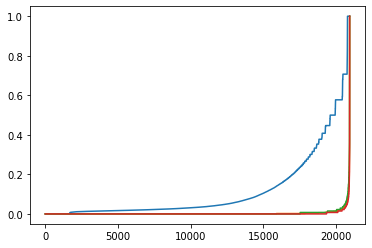

In [48]:
plt.plot(np.sort(genes_and_counts_df['skew'])/genes_and_counts_df['skew'].max())
plt.plot(np.sort(genes_and_counts_df['max'])/genes_and_counts_df['max'].max())
plt.plot(np.sort(genes_and_counts_df['median'])/genes_and_counts_df['median'].max())
plt.plot(np.sort(genes_and_counts_df['std'])/genes_and_counts_df['std'].max())
#plt.yscale('log')